In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('sx-mathoverflow')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: True


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


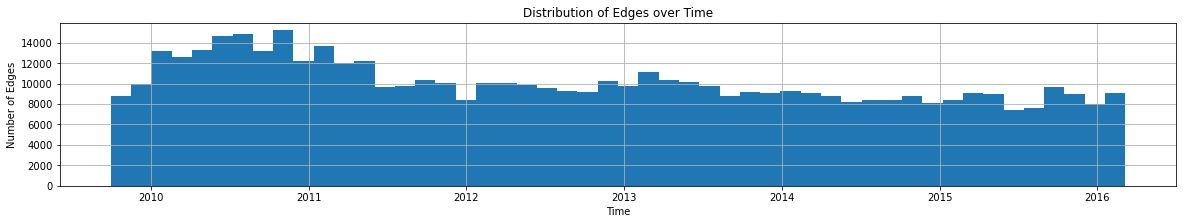

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 24818
Number of Edges: 506550
Density: 0.0008224438525432063


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 40.821178177129504
Median Degree: 6.0


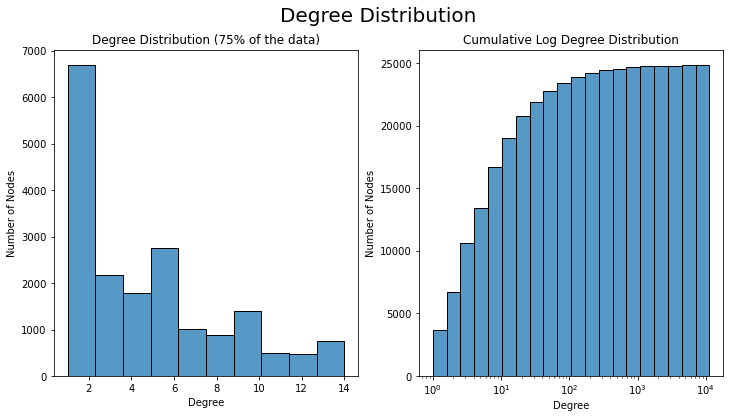

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,11309,1946
1,8599,290
2,8412,6094
3,7998,11142
4,6399,297
5,5360,763
6,5167,1409
7,5132,2841
8,4872,18060
9,4832,2926


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [32]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [33]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.45
Diameter: 6


In [34]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,13095.000000,13095.000000,1.309500e+04,13095.000000,11742.000000
mean,0.001932,0.000230,3.424057e-03,0.000076,0.403330
std,0.005808,0.009386,8.040261e-03,0.000206,0.300919
min,0.000076,0.000000,1.193914e-07,0.000013,0.000000
25%,0.000229,0.000000,4.179524e-04,0.000021,0.194805
50%,0.000535,0.000000,1.004432e-03,0.000028,0.333333
75%,0.001298,0.000000,2.711951e-03,0.000052,0.563636
max,0.141744,1.000076,1.345253e-01,0.005093,1.000000


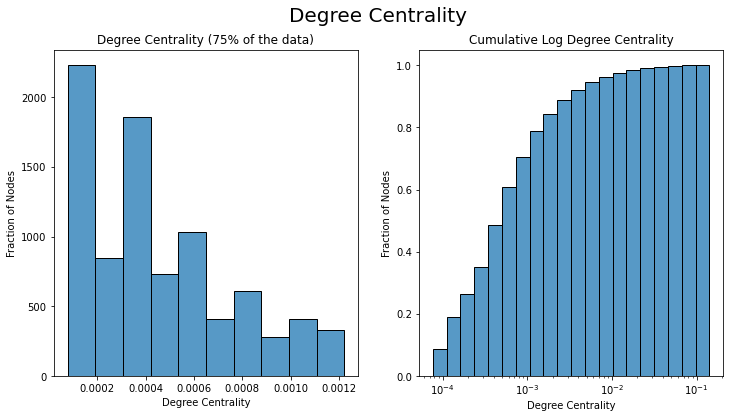

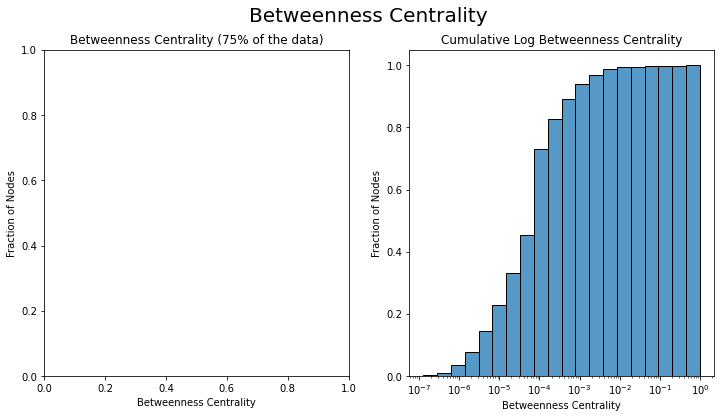

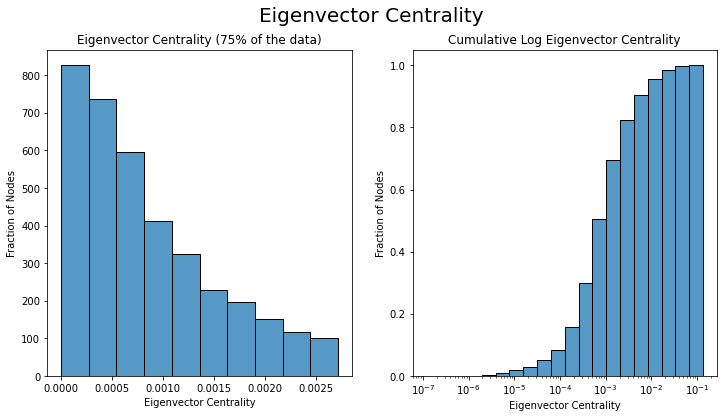

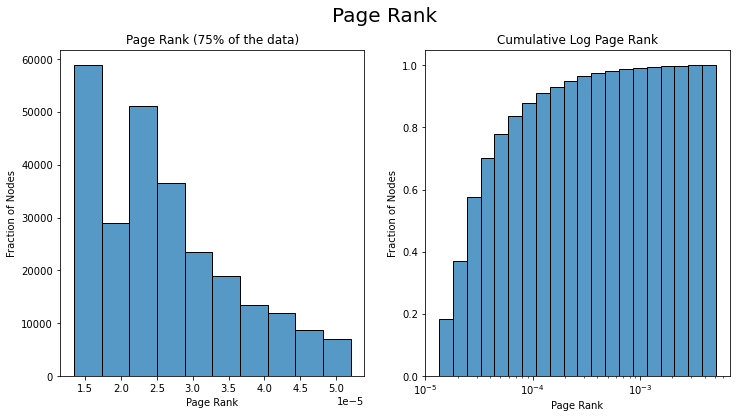

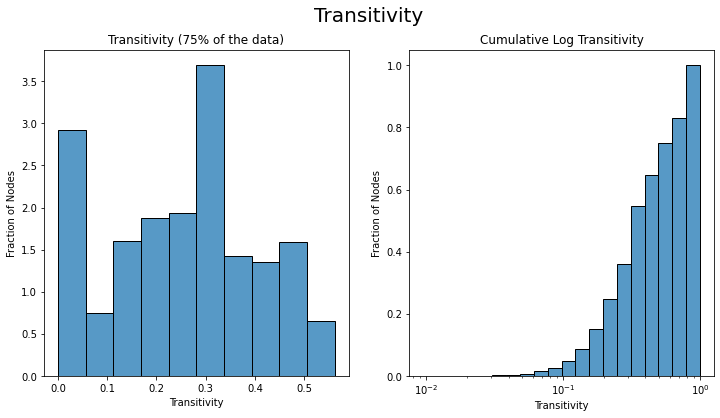

In [35]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [36]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.141744,290,1.000076,27909,0.134525,290,0.005093,11142,1.0,88573
1,0.124637,11142,0.242666,6950,0.113375,1409,0.004934,290,1.0,31048
2,0.107912,763,0.225370,15629,0.108355,297,0.004150,763,1.0,80194
3,0.102795,1409,0.093300,15242,0.105615,11142,0.003801,6094,1.0,7702
4,0.099511,297,0.091469,51663,0.100756,121,0.003631,3684,1.0,61134
5,0.095005,3684,0.072046,4333,0.098933,763,0.003505,1409,1.0,30735
6,0.095005,121,0.064063,14835,0.095771,6094,0.003466,297,1.0,61293
7,0.093020,6094,0.061143,36720,0.094044,2926,0.003341,121,1.0,61338
8,0.086452,2926,0.059252,66688,0.093906,1149,0.003290,1946,1.0,7740
9,0.084772,1946,0.045832,25854,0.092043,2841,0.003197,2926,1.0,80081


## Connected Components Statistics

In [37]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 11626
Size of the largest component: 13095


Text(0.5, 1.0, 'Connected Components')

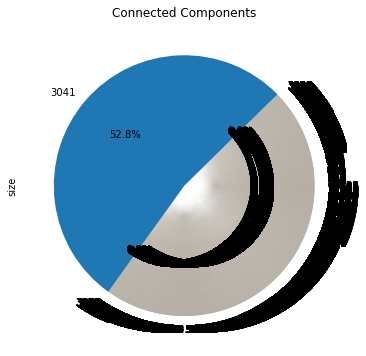

In [38]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [39]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
User,User,24818,40.821178,6.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

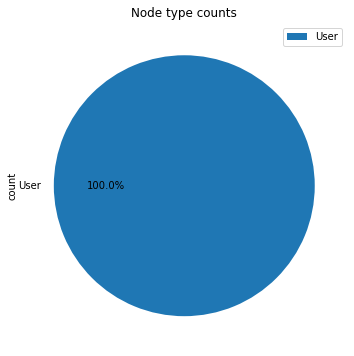

In [40]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

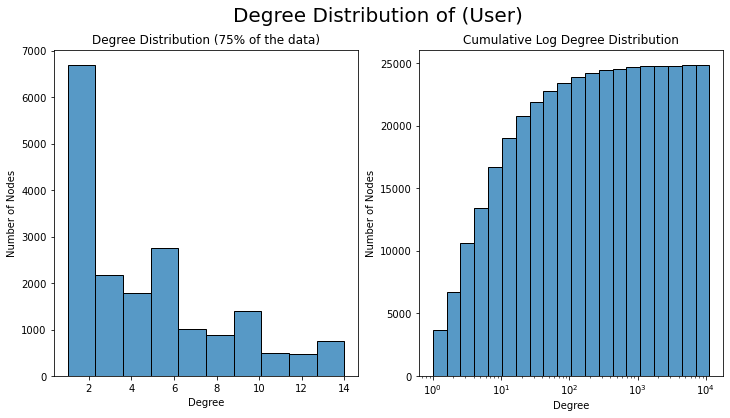

In [41]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [42]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,11309,1946
1,8599,290
2,8412,6094
3,7998,11142
4,6399,297
5,5360,763
6,5167,1409
7,5132,2841
8,4872,18060
9,4832,2926


### Edge Type Statistics

In [43]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
ANSWERED_QUESTION,ANSWERED_QUESTION,107581
COMMENTED_ON_ANSWER,COMMENTED_ON_ANSWER,195330
COMMENTED_ON_QUESTION,COMMENTED_ON_QUESTION,203639


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

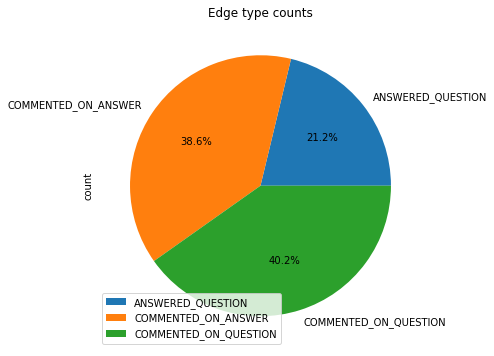

In [44]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [45]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [46]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.141744,290,1.000076,27909,0.134525,290,0.005093,11142,1.0,9872
1,0.124637,11142,0.242666,6950,0.113375,1409,0.004934,290,1.0,69232
2,0.107912,763,0.225370,15629,0.108355,297,0.004150,763,1.0,30950
3,0.102795,1409,0.093300,15242,0.105615,11142,0.003801,6094,1.0,36530
4,0.099511,297,0.091469,51663,0.100756,121,0.003631,3684,1.0,3762
5,0.095005,121,0.072046,4333,0.098933,763,0.003505,1409,1.0,15033
6,0.095005,3684,0.064063,14835,0.095771,6094,0.003466,297,1.0,26030
7,0.093020,6094,0.061143,36720,0.094044,2926,0.003341,121,1.0,15044
8,0.086452,2926,0.059252,66688,0.093906,1149,0.003290,1946,1.0,15060
9,0.084772,1946,0.045832,25854,0.092043,2841,0.003197,2926,1.0,30956


# Clustering

## No Clustering Modularity

In [47]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [48]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.3163348562574049
Number of communities: 18


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

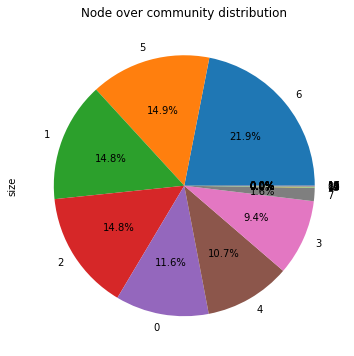

In [49]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [50]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.141744,290,0.027220,290,0.134525,290,0.004934,290,1.0,957
1,0.072934,454,0.005982,4832,0.086936,454,0.002625,454,1.0,2908
2,0.047350,1459,0.004781,1847,0.075104,1459,0.001734,4832,1.0,790
3,0.046815,1847,0.004746,454,0.071072,1532,0.001644,1847,1.0,7702
4,0.045441,1353,0.003198,1459,0.070119,1353,0.001567,1459,1.0,23995
5,0.044524,4832,0.003089,1004,0.066633,1450,0.001493,1532,1.0,66255
6,0.044142,1532,0.002916,440,0.064106,1847,0.001400,1353,1.0,7600
7,0.039407,1450,0.002636,8212,0.062923,45,0.001248,1450,1.0,3204
8,0.039102,45,0.002165,1353,0.058349,6316,0.001223,45,1.0,3283
9,0.035665,1,0.001971,22,0.057172,1587,0.001157,6316,1.0,74661


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.102795,1409,1.000076,27909,0.113375,1409,0.003505,1409,1.0,88573
1,0.095005,121,0.242666,6950,0.100756,121,0.003341,121,1.0,34290
2,0.083855,18060,0.093300,15242,0.087500,18060,0.003076,18060,1.0,34336
3,0.066366,4231,0.072046,4333,0.077139,4721,0.002346,4231,1.0,34593
4,0.050939,66,0.061143,36720,0.070094,66,0.001738,13265,1.0,34596
5,0.047808,4721,0.045832,25854,0.069748,4231,0.001656,66,1.0,34620
6,0.047655,391,0.037880,39380,0.067047,391,0.001598,391,1.0,34658
7,0.047121,2874,0.016200,18060,0.063260,2874,0.001530,4721,1.0,34722
8,0.044448,13265,0.015375,1409,0.062691,450,0.001491,2874,1.0,35566
9,0.040324,4144,0.015208,121,0.056941,83,0.001377,40297,1.0,36130


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.086452,2926,0.016653,1946,0.094044,2926,0.003290,1946,1.0,88484
1,0.084772,1946,0.015650,2926,0.092043,2841,0.003197,2926,1.0,16549
2,0.076065,2841,0.011165,4177,0.088435,1946,0.002556,2841,1.0,15918
3,0.068505,4177,0.010917,6794,0.083782,78,0.002414,4177,1.0,32290
4,0.062548,78,0.010795,12705,0.083093,4177,0.002327,6794,1.0,32186
5,0.061937,6794,0.007692,2841,0.077606,3106,0.002200,12705,1.0,32010
6,0.055063,12705,0.006399,78,0.068768,5690,0.002039,78,1.0,31954
7,0.050863,3106,0.004549,5690,0.067972,6794,0.001755,2000,1.0,4826
8,0.049488,2000,0.003594,12166,0.065494,2000,0.001697,3106,1.0,31727
9,0.049030,5690,0.003546,75,0.064298,15934,0.001627,5690,1.0,31684


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.099511,297,0.225370,15629,0.108355,297,0.003466,297,1.0,4588
1,0.074232,1149,0.014894,297,0.093906,1149,0.002426,1149,1.0,2898
2,0.060409,2530,0.008071,2290,0.081346,2530,0.002060,2530,1.0,8764
3,0.054147,3272,0.005911,1149,0.075930,3272,0.001851,2384,1.0,4990
4,0.052543,2384,0.005840,3272,0.071792,2384,0.001800,2290,1.0,75178
5,0.050481,2290,0.005583,2530,0.070146,5740,0.001793,3272,1.0,13828
6,0.049336,3324,0.002811,2481,0.066876,1384,0.001762,3324,1.0,13807
7,0.045746,1384,0.002745,2384,0.063904,3324,0.001481,1384,1.0,49242
8,0.045746,5740,0.002696,10400,0.063231,2290,0.001480,5740,1.0,13369
9,0.032305,10400,0.002535,3324,0.056042,431,0.001140,10400,1.0,37187


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.050634,1345,0.064063,14835,0.068553,317,0.001787,1345,1.0,88381
1,0.046586,317,0.007215,1345,0.061518,1345,0.001575,14094,1.0,15060
2,0.043684,21684,0.006200,14094,0.060718,6976,0.001575,21684,1.0,50181
3,0.043073,6976,0.005082,14450,0.060470,2051,0.001550,6976,1.0,14548
4,0.042233,14094,0.004170,317,0.059513,10446,0.001532,317,1.0,50433
5,0.040782,10446,0.003649,1463,0.049627,1463,0.001432,10446,1.0,50449
6,0.036811,1463,0.003493,21684,0.049316,21684,0.001277,1463,1.0,14250
7,0.035971,2051,0.003274,35840,0.044054,14094,0.001199,14450,1.0,50509
8,0.032458,14450,0.002822,2051,0.044021,1573,0.001194,2051,1.0,50611
9,0.029403,1573,0.002576,6976,0.042581,8176,0.000989,1573,1.0,50699


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.071712,1465,0.059252,66688,0.079029,1465,0.002637,6101,1.0,171
1,0.068657,6101,0.011543,25510,0.075064,6101,0.002496,1465,1.0,26191
2,0.058882,613,0.010001,6101,0.071423,8799,0.002117,613,1.0,27801
3,0.055369,3948,0.007593,1465,0.068957,613,0.002105,3948,1.0,27751
4,0.053460,8799,0.006170,13972,0.064338,1441,0.002086,25510,1.0,27611
5,0.051932,25510,0.006032,613,0.062707,394,0.001981,8799,1.0,27580
6,0.047808,1441,0.005061,20302,0.062384,3948,0.001747,1441,1.0,27547
7,0.045899,394,0.004932,3948,0.060018,4362,0.001677,13972,1.0,27404
8,0.042920,20302,0.004721,353,0.057504,25510,0.001669,20302,1.0,27266
9,0.040782,13972,0.004494,1441,0.048494,20302,0.001544,394,1.0,27001


No node timestamp data available


### Label Propagation

In [51]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.00027771295047931103
Number of communities: 20


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

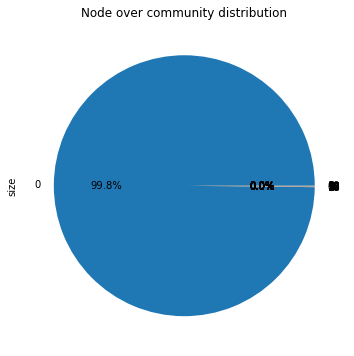

In [52]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [53]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.141744,290,1.000076,27909,0.134525,290,0.005093,11142,1.0,88573
1,0.124637,11142,0.242666,6950,0.113375,1409,0.004934,290,1.0,41971
2,0.107912,763,0.225370,15629,0.108355,297,0.004150,763,1.0,21570
3,0.102795,1409,0.093300,15242,0.105615,11142,0.003801,6094,1.0,21566
4,0.099511,297,0.091469,51663,0.100756,121,0.003631,3684,1.0,7537
5,0.095005,3684,0.072046,4333,0.098933,763,0.003505,1409,1.0,41262
6,0.095005,121,0.064063,14835,0.095771,6094,0.003466,297,1.0,21533
7,0.093020,6094,0.061143,36720,0.094044,2926,0.003341,121,1.0,3331
8,0.086452,2926,0.059252,66688,0.093906,1149,0.003290,1946,1.0,21532
9,0.084772,1946,0.045832,25854,0.092043,2841,0.003197,2926,1.0,41376


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000229,3268,0.0,3268,0.00002,3268,0.000026,3268,NaN,3268


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000305,3358,0.0,3358,0.000300,3358,0.000033,3407,0.0,3358
1,0.000305,3407,0.0,3407,0.000152,3407,0.000033,3358,0.0,3407


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000229,6612,0.0,6612,0.000058,6612,0.000024,6612,NaN,6612


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000229,8469,0.0,8469,0.000143,8469,0.000025,8469,NaN,8469


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000229,21220,0.0,21220,0.00013,21220,0.000024,21220,NaN,21220


No timestamp data available
